# Suppress Printing

In [129]:
import sys, os
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__

# Load Back Projected ICA Data

In [130]:
import scipy.io as sio

In [131]:
enablePrint()
filepath = '/Users/apple/Desktop/eeglab14_1_2b/ICA_Data/EEGData1.mat'
mat_contents = sio.loadmat(filepath)
ica = mat_contents['data']
temp_trial = ica[:,:,1]
trial = ica.shape[2]
print("{}: {}".format("Total number of trials is", trial))
channel = temp_trial.shape[0]
print("{}: {}".format("Total number of channels in each trial is", channel))
timepoint = temp_trial.shape[1]
print("{}: {}".format("Total number of time points in per channel per trial is", timepoint))

# Testing between 1 trial 2 channels with GC

In [132]:
import statsmodels.tsa.stattools as stm
import numpy as np

In [133]:
#we just gonna pick temp_trial
print(temp_trial.shape)
temp_trial = temp_trial[:,1::10]
print(temp_trial.shape)

In [134]:
a = np.asarray(temp_trial[0,:])
b = np.asarray(temp_trial[1,:])
x = np.vstack((a, b)).T
print(x.shape)

In [136]:
from statsmodels.tsa.ar_model import AR
model = AR(a)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
maxlag = model_fit.k_ar
if maxlag > 5:
    maxlag =5

In [137]:
addconst = True
verbose = True

In [138]:
result = stm.grangercausalitytests(x, maxlag, addconst, verbose)
optimal_lag = -1
F_test = -1.0
for key in result.keys():
    _F_test_ = result[key][0]['params_ftest'][0]
    if _F_test_ > F_test:
        F_test = _F_test_
        optimal_lag = key

In [139]:
print("{} {}".format("We are going to look into the GC with Optimal Lag of", optimal_lag))

We consider the p-value of the test as a measure for Granger causality: rejection of ℋ0 (p < 0.03) signifies Granger causality, acceptance means non-causality.

The causality relations drawn from systems with very small values of |det(ΛˆI)| are not meaningful

In [140]:
if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
    print(result[optimal_lag][0]['params_ftest'][0])

# Compute one Multivariant Granger Causality Matrix MGCM

In [141]:
from matplotlib import pyplot
import math
import time

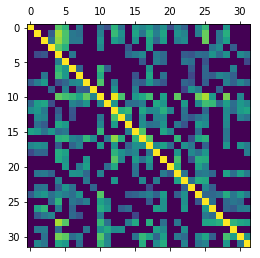

In [142]:
time_start = time.clock()
MGCM = np.zeros((channel,channel))
for i in range(channel):
    for j in range(channel):
        if i == j:
            enablePrint()
            print("{}:{}".format(i,j))
            MGCM[i,j] = 0
        blockPrint()
        a = np.asarray(temp_trial[i,:])
        b = np.asarray(temp_trial[j,:])
        x = np.vstack((a, b)).T
        model = AR(a)
        model_fit = model.fit()
        maxlag = model_fit.k_ar
        if maxlag > 5:
            maxlag = 5
        result = stm.grangercausalitytests(x, maxlag, addconst = True, verbose = True)
        optimal_lag = -1
        F_test = -1.0
        for key in result.keys():
            _F_test_ = result[key][0]['params_ftest'][0]
            if _F_test_ > F_test:
                F_test = _F_test_
                optimal_lag = key
        if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
            MGCM[i,j] = math.log(result[optimal_lag][0]['params_ftest'][0])
        else:
            MGCM[i,j] = 0
enablePrint()
diag = np.max(MGCM)
print(diag)
for i in range(channel):
    for j in range(channel):
        if i == j:
            MGCM[i,j] = 1
        else:
            MGCM[i,j] = MGCM[i,j]/diag
pyplot.matshow(MGCM)
pyplot.show()
time_elapsed = (time.clock() - time_start)
print("{}: {}".format("Time Used", time_elapsed))

In [143]:
print(np.mean(MGCM))
print(np.median(MGCM))
print(np.max(MGCM))
print(np.min(MGCM))

In [149]:
print("{}:{}".format("Hours needed", 34*40*32/60/60))

In [150]:
#GoogleColab takes 34 seconds